In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import nltk
from html.parser import HTMLParser

In [2]:
prof = pd.read_csv("../professionals.csv")
answ = pd.read_csv("../answers.csv")
stud = pd.read_csv("../students.csv")
ques = pd.read_csv("../questions.csv")
emai = pd.read_csv("../emails.csv")
matc = pd.read_csv("../matches.csv")
tagq = pd.read_csv("../tag_questions.csv")
taqu = pd.read_csv("../tag_users.csv")

Where professionals and students are from (locations and number). Which locations have both professionals and students. 

In [3]:
print(prof.professionals_location.value_counts().head(10))
print("\n")
print(stud.students_location.value_counts().head(10))

p_loc = np.array(prof['professionals_location'].values.tolist())
s_loc = np.array(stud['students_location'].values.tolist())

i = np.intersect1d(p_loc,s_loc)
print("\nThese are the locations with both professionals and students: {}".format(i))
print("\nIn total, there are {} locations with both professional and students".format(i.size))


New York, New York            1337
California, California         864
Greater New York City Area     745
Boston, Massachusetts          714
Los Angeles, California        617
Atlanta, Georgia               578
Chicago, Illinois              576
Austin, Texas                  574
Houston, Texas                 556
San Francisco Bay Area         513
Name: professionals_location, dtype: int64


New York, New York             1313
Bengaluru, Karnataka, India     890
Los Angeles, California         663
Hyderabad, Telangana, India     597
Boston, Massachusetts           557
San Francisco, California       550
San Jose, California            548
Houston, Texas                  476
Chennai, Tamil Nadu, India      437
Chicago, Illinois               344
Name: students_location, dtype: int64

These are the locations with both professionals and students: ['Abilene, Texas' 'Abu Dhabi, United Arab Emirates' 'Abuja, FCT, Nigeria'
 ... 'York, Pennsylvania' 'Ypsilanti, Michigan' 'nan']

In total, ther

[Text(0, 0, 'New York, New York'),
 Text(0, 0, 'California, California'),
 Text(0, 0, 'Greater New York City Area'),
 Text(0, 0, 'Boston, Massachusetts'),
 Text(0, 0, 'Los Angeles, California'),
 Text(0, 0, 'Atlanta, Georgia'),
 Text(0, 0, 'Chicago, Illinois'),
 Text(0, 0, 'Austin, Texas'),
 Text(0, 0, 'Houston, Texas'),
 Text(0, 0, 'San Francisco Bay Area'),
 Text(0, 0, 'San Francisco, California'),
 Text(0, 0, 'Bengaluru, Karnataka, India'),
 Text(0, 0, 'Philadelphia, Pennsylvania'),
 Text(0, 0, 'Greater Atlanta Area'),
 Text(0, 0, 'Dallas/Fort Worth Area'),
 Text(0, 0, 'Greater Los Angeles Area'),
 Text(0, 0, 'Washington'),
 Text(0, 0, 'Greater Chicago Area'),
 Text(0, 0, 'Houston, Texas Area'),
 Text(0, 0, 'Greater Boston Area')]

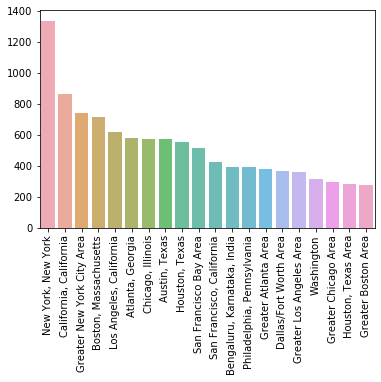

In [4]:
## Let's plot this in bar graph form
location_count = prof['professionals_location'].value_counts()
location_count = location_count[:20,]

g = sns.barplot(location_count.index, location_count.values, alpha=0.8)
g.set_xticklabels(location_count.index, rotation=90)

[Text(0, 0, 'New York, New York'),
 Text(0, 0, 'Bengaluru, Karnataka, India'),
 Text(0, 0, 'Los Angeles, California'),
 Text(0, 0, 'Hyderabad, Telangana, India'),
 Text(0, 0, 'Boston, Massachusetts'),
 Text(0, 0, 'San Francisco, California'),
 Text(0, 0, 'San Jose, California'),
 Text(0, 0, 'Houston, Texas'),
 Text(0, 0, 'Chennai, Tamil Nadu, India'),
 Text(0, 0, 'Chicago, Illinois'),
 Text(0, 0, 'Oakland, California'),
 Text(0, 0, 'San Antonio, Texas'),
 Text(0, 0, 'Dallas, Texas'),
 Text(0, 0, 'Owensboro, Kentucky'),
 Text(0, 0, 'Providence, Rhode Island'),
 Text(0, 0, 'Lakeland, Florida'),
 Text(0, 0, 'Pittsburgh, Pennsylvania'),
 Text(0, 0, 'Irving, Texas'),
 Text(0, 0, 'Miami, Florida'),
 Text(0, 0, 'Atlanta, Georgia')]

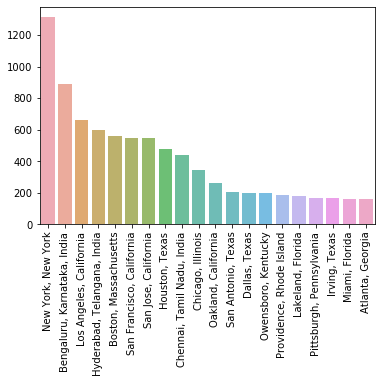

In [5]:
location_count2 = stud['students_location'].value_counts()
location_count2 = location_count2[:20,]
f = sns.barplot(location_count2.index, location_count2.values, alpha=0.8)
f.set_xticklabels(location_count2.index, rotation=90)

Which industries are most of these professionals in?

In [6]:
prof.professionals_industry.value_counts().head(10)

Telecommunications                     3166
Information Technology and Services    2109
Computer Software                      1272
Hospital and Health Care                862
Higher Education                        800
Accounting                              781
Financial Services                      639
Education Management                    593
Marketing and Advertising               526
Internet                                427
Name: professionals_industry, dtype: int64

[Text(0, 0, 'Telecommunications'),
 Text(0, 0, 'Information Technology and Services'),
 Text(0, 0, 'Computer Software'),
 Text(0, 0, 'Hospital and Health Care'),
 Text(0, 0, 'Higher Education'),
 Text(0, 0, 'Accounting'),
 Text(0, 0, 'Financial Services'),
 Text(0, 0, 'Education Management'),
 Text(0, 0, 'Marketing and Advertising'),
 Text(0, 0, 'Internet'),
 Text(0, 0, 'Human Resources'),
 Text(0, 0, 'Mechanical or Industrial Engineering'),
 Text(0, 0, 'Management Consulting'),
 Text(0, 0, 'Research'),
 Text(0, 0, 'Non-profit Organization Management'),
 Text(0, 0, 'Law Practice'),
 Text(0, 0, 'Entertainment'),
 Text(0, 0, 'Health, Wellness and Fitness'),
 Text(0, 0, 'Medical Practice'),
 Text(0, 0, 'Computer Hardware')]

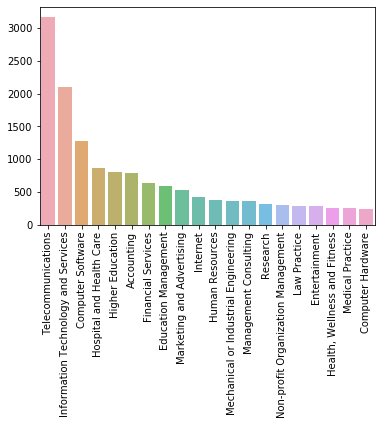

In [7]:
## Let's plot this as a barp graph
industry_count = prof['professionals_industry'].value_counts()
industry_count = industry_count[:20,]
g = sns.barplot(industry_count.index, industry_count.values, alpha=0.8)
g.set_xticklabels(industry_count.index, rotation=90)


What are key words (NN) from students' questions? First strip html tags from answers and questions and access the nouns using nltk.tag_pos() and nltk.word_tokenizer()

Here we can then plot all the different NN* to see what words are "big" in students' questions. 

In [11]:
## This class strips all HTML encoding in the responses 
## It takes in a string and returns an HTML-free string
## Usage: strip_tags(df.text_body.iloc[i]) for i in range(0:df.size)

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)
    
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


In [65]:
## method to get all the answer body texts in one string
def getQuesText(ques) -> str:
    result = ""
    for index, row in ques.iterrows():
        a = (row['questions_body'])
        a = strip_tags(a)
        result += a
    return result
a = getQuesText(ques)

In [82]:
### tokenize the answers and then classify parts of speech. Keep words that are NN
### Make a dictionary to update the frequency of these individual words across all words. 
# w = word dictionary (pass by reference)
# t = tokenized string

def idNounsFromText(words, t) -> dict:
    t = (nltk.word_tokenize(t))
    print('Finished tokenizing body text')
    
    t = nltk.pos_tag(t)
    print('Finished tagging pos in body text')
    
    for i in t: 
        if (i[1] == "NN" or i[1] == "NNP" or i[1] == "NNS" or i[1] == "NNPS"):
            current = i[0].lower()
            if current in words.keys(): 
                words[current] += 1
            else:
                words[current] = 1
    return w

#print(a)
w = idNounsFromText(w, a)
#print(w)
for k,v in w.items():
    print(k,v)

Finished tokenizing body text
Finished tagging pos in body text
teacher 1403
college 27611
lecturei 20
priyanka 17
bangalore 50
std 221
officer 476
question 3794
job 9692
career 15056
ideas 548
difference 653
something 2702
ways 893
side 383
employers 458
hear 20
business 6104
management 1709
way 2555
areas 467
networking 173
scholarships 2372
year 4568
students 2336
states 317
ga. 14
any 110
help 2063
firstgeneration 26
love 695
science 5804
music 2288
soccer 335
i 7079
sense 203
years 3512
sport 206
buildingi 17
someone 1703
subject 401
graphicsi 17
sophomore 1232
anesthesiologist 152
steps 653
order 1211
fun 308
doctor 3890
experience 3377
majors 1949
woman 155
color 29
workplace 128
scientistsi 2
engineer 2255
day 1811
construction 344
worker 260
tools 65
building 176
things 3107
hour 101
desk 83
civil 164
medium 44
case 365
mathematics 761
process 752
lawyer 1391
lsat 47
or 47
law 2441
school 17672
harvard 77
bachelor 905
master 668
program 2162
summer 1160
planning 206
practice 5

enemy 2
surveillance 11
intelligence 65
nfo 2
aerodynamics 11
engine 17
meteorology 53
navigation 2
ea-6b 2
prowler 2
f/a-18 2
hornet 5
jet 8
fighters 2
e-2c 2
hawkeye 2
warning 8
control 89
p-8a 2
poseidon 2
electronically 2
detect 2
ships 11
submarines 2
missiles 2
designing 95
note 59
york/ 2
milan/ 2
paris 5
/ 68
london 29
restrictions 17
pls 44
biotechi 11
psychologist 359
compensationi 14
post 110
call 47
backs 8
job-application 167
mechanical-engineering 44
semester 653
session 29
offers 89
honors 191
programmer 164
robot 44
robotc 2
visitshi 2
kylea 5
resame 2
er/doctor 2
eri 2
msn 29
ecu 5
boati 2
hai 53
disease 71
diseases 71
geography 56
> 20
penn 26
park 71
college-tuition 41
eberly 2
midst 11
instance 29
inspection 5
testing 17
ndt 8
methods 143
materials 101
modules 17
cv/resume 5
clinic 71
therapist 476
lots 284
shoulders 8
clinici 2
game 800
gaming 83
developersi 5
anyfor 2
non 8
college-classes 8
technologyi 71
accountingi 56
past 44
eye 86
job-applications 29
fellowsh

korea 35
canada 152
mathi 65
astronomy 107
theoretical 8
speed 20
simulation 2
consensus 5
astrophysicist 11
theoreticalmy 2
suhey 2
ruby 11
valley 32
albuquerque 5
nm 2
bass 20
piano 92
berkeley 17
musici 50
neurologist 47
medicarei 2
pharmaceuticalsi 29
pyschologyi 8
job/internship-searching 2
skype 8
dorm/suite 2
seconds 20
impression 65
interviewsfuture 2
generali 50
speaking 122
presentation 29
portion 29
talenti 5
lecture 32
race 47
belongs 2
social-networkingin 2
kinesiology 122
exercisescience 5
krysta 2
nicu 47
marinebiologyi 2
university-applications 11
ny 14
la 38
capital 23
cities 56
expert 59
bar 56
bioinformatics 44
bioinformaticsi 8
dakota 23
copdo 2
webistes 2
newborns 11
self-employment 5
growing-jobsi 2
achievement 26
contributions 11
improvement 14
performing 53
break 110
auditions 44
roles 44
fat 5
load 128
music-education 47
spanish-education 2
dualmajor 5
animationi 20
plenty 41
horticulture 2
livestock 5
horticulturei 2
inspire 5
grocery 17
baskets 2
cashiers 5
s

scholarshipsits 2
schoool 2
detail 47
electrical-engineeringbecause 2
biology/zoology 2
film-making 2
vision 20
broadway 35
productions 17
choreographer 14
setter 2
va 5
powers 2
reputations 5
daytodaylifeproject 2
projectmanagementi 2
honorscollege 5
northeastern 8
crossroads 8
coursesi 29
michigan 62
extent 50
scenarios 11
workercustomer 2
mrs 5
winners 5
thru 14
helper 8
kroger 2
cashier 8
scientific 5
atlanta 29
.this 2
satelites 2
beaver 2
pkwy 2
duluth 2
lilburn 2
quickly 2
phases 2
pc 20
masking 2
screqw 2
loved 8
offs 2
association 20
ga 11
wang 5
co. 2
bus 14
routes 17
contractors 17
ordersdid 2
contracts 14
yr 14
girerealestate 2
over 8
trucking 2
til 5
swervices 2
operatinghi 2
gwhs 2
summerschool 5
theory 56
curriculumi 2
colombia 2
bussines 2
lifei 35
multimedia 14
multimediai 5
histotechnologist 2
histology 2
illustration/animation 2
jose 65
clueless 17
genes 2
diseasesi 5
boring 8
spreadsheets 5
majorsi 41
northeast 5
software-engineering 11
sfpd 5
resident 14
wait 32
ci

cover-letters 35
job-searchingjust 2
natural 8
anyway 17
ease 20
aircraftmaintenace 8
cheifengineer 2
aviationuniversities 2
collegeplease 2
hunter/city 2
marketing.. 2
cyber-security 38
information-securitywhat 2
salesman 5
charlie 11
secondary-education 14
categories 14
lone 8
throughout 5
autocadd 2
revit 2
applicablei 2
baggage 2
tesol 17
life-coach 5
small/medium 2
computersciencei 5
transgender 2
lgbtqa 5
pay-off 2
table 14
prioritizing 2
special-education 20
fuels 5
brainstorm 2
combustion 5
chamber 11
ionization 2
waves 11
heats 2
as 20
crazy 23
trek 8
plasma 2
neurosurgeons 5
leadershipi 5
astronomyi 5
station 20
orbs 2
field/dream 2
respectablebusinessmatters 2
doctoral 5
side-job 2
configuration 5
hearing 32
commercial-aviation 2
rap 11
rhymesi 5
robotics-engineeri 2
organ 5
muscles 11
mahalakshmi 2
ghs 155
professionalafter 5
bar-exam 2
sheet 5
spots 11
lifethis 2
endeavors 26
atmospheric 11
aeronautic 2
speakingmy 2
mycology 5
field-work 5
speail 2
help.as 2
honestyi 2
int

poors 2
vocalperformance 5
shine 2
healthcare-iti 5
alternatives 14
horizon 2
rolle 2
theroem 2
businessperson 2
investor 26
suchlike 2
pakistan 8
omid 2
efc 5
stubs 2
simply 8
rise 20
client-counselor 2
life-skills 11
mange 2
iatse-891because 2
beings 11
operating 17
pre-medicine/medicine 2
mexico 20
till 17
targeting 2
languagehi 2
area/department/work 2
automobilei 2
scouts 14
philanthropy 5
defects 2
golfing 5
*everything* 2
loves 8
hit 8
miss 2
needfunds 2
numismatics 2
counterargument 5
something. 2
adulthood 11
laziness 5
foodi 5
puzzling 2
graduationsorority 2
persona 2
schoolorganizations 2
collegereality 2
correlation 2
policefbla 2
gravity 2
college-applicationstrying 2
college-lifei 5
classesis 2
cheaper 2
nursedo 2
alumn 2
crad 2
clinicalresearch 2
crai 2
expertsi 11
ireland 14
england 29
cota 8
extreme 5
beautyi 5
computing 17
mason 14
concerts 11
cs/ux-design 2
gmu 2
virginiatechi 2
a-level 14
dramai 14
collegeloands 2
collegedebt 11
collegewhen 5
help.many 2
criminalpsy

armed-forcesi 2
grills 2
pages 11
clint 8
vists 2
hospital-and-health-careabout 2
medex 2
healthcaremy 2
collegestationdoes 2
stemi 14
years/ 2
schreiner 2
christi 2
//www.youtube.com/watch 14
v=7de8lny-ldm 2
tennisi 2
sports-managementas 2
ops 2
codi 2
supports 5
lovehey 2
njit 5
rowan 5
industrialengineer 2
cnc 5
engineeringstudentwhen 2
studentjust 2
optometrists 2
residency12 2
nonprofitsi 2
praxis 11
aslo 2
networkingi 8
airline-pilot 2
raise 8
money-makersinternships 2
guide 47
transferring 11
accreditation 14
are.animation 2
workwe 2
cosmetologybecause 2
careerchoices 2
course/curriculum 2
individual-and-family-services 5
family-therapy 2
classxii 2
experience/certification 8
answer/comments 2
physiciansi 5
multitasking 2
journalisti 11
servicewhat 2
travelabroad 2
chloe 5
o. 2
researcherwould 2
peopleshould 2
art-college 2
commentator 5
vi 2
viet 2
nam 2
parents.i 2
.when 2
lump 2
subsidized 2
stafford 5
govt. 2
loanshow 2
string 2
anesthesiai 2
tutitions 2
medicaid 2
homeworki

market-trading 2
sticks 2
artisthi 2
livia 2
experiencesi 8
creditscores 2
pioneer 2
regional 2
human-resourcesinterviews 2
company/organization 2
culinaryi 26
duty 20
sports-law 5
creativei 11
inforcement 2
grandfather 14
rising 8
aguilera 2
nk 2
suspects 2
classical-musici 2
meritsmy 2
collegeleadershipclub 2
woodworking 5
tastes 2
pre-med/biology 8
aca 2
soft 2
ware 5
enginehello 2
iraafultonschoolsofengineeringi 2
sleepif 2
careeris 2
newbie 8
harassment 2
punishment 5
peyton 17
myth 8
skidds 2
journalistsi 2
lights 5
gamers 5
pedro 5
andres 2
caceres 2
subjects/majors 2
clarkson 2
endeavor 11
earlyadmissions 5
before/after 2
historymy 2
senad 2
sporti 14
performing-artslooking 2
surgeonmy 2
familylaw 2
window 8
pickmeoverhimi 2
ewre 2
civil-engineer 5
environmental-engineer 2
environmental-engineering 2
water-resources 2
burnout 8
countless 8
copingmethodsi 2
mid-wife 5
helps 2
police-office 2
michelle 5
specialeducation 5
ini 8
medicinehi 5
pediatricnurse 2
soundtrack 2
ep 8
game

grain 2
computerhey 2
butt 5
you.i 5
educational 8
heights 2
richi 5
bs/md 2
bsmeprogramsi 2
patholgist 2
classof'22how 2
etude 2
virtual-realityi 2
future-career 5
nanotech 2
studentabout 2
approval 2
patiencei 2
msu 2
teachercertification 2
interships 8
patterns 8
highwaysi 2
barista 5
disneyi 2
environmental/conservation/coldwater 2
essential 2
jaylen 2
athleticsplease 2
mcatstudents 2
full-timeim 2
training-delivery 2
entertainmenti 8
troubles 2
cakewalk 2
turkey.my 2
cmu 2
world.as 2
purpose.however 2
midterms 11
carelessness.fot 2
exam.how 2
orhi 2
jobexperience 2
therapy.. 2
informational 5
thrill 5
outfits 2
generaleducation 2
sanctuaryi 2
liability 2
dance-educationi 2
indecisive 5
kannada 5
pharmacywhen 2
valedictoriancollege 2
collegelike 2
specify 2
gob 2
human-resourcesis 2
vijayakumar 2
counsellinghow 2
transferstudent 2
mates 2
meditation 2
deathi 2
pensions 5
travelingbecause 2
financebecause 5
how-to-start-a-business-in-any-industry 5
cashforbusiness 2
computer-program

deans 2
educatorpeople 2
networksi 2
chemisti 5
ima 2
already 2
pushes 2
investment-bankingi 5
criminal-lawwhat 2
major/school 2
infomationtechnologyi 2
physical-therapyif 2
therapisthello 2
choosing-a-career 5
extremity 2
bid 2
bdes 2
bs-made 2
majors/fields 5
what-the-university-offers 2
careersanyone 2
enterprisei 2
obgyni 5
paralegalshello 2
professional-sportsbecome 2
psychiatryhi 2
sudharani 2
naysa 2
congressmen 2
delegates 2
videois 2
helpingi 2
corporatei 2
westwood 2
accounter 2
buddism 2
germanmany 2
community-managementwhat 2
guider 2
qution 2
geneticists 2
geneticswant 2
resourcesim 2
hints 5
skillset 5
dietitianif 2
copingmethods 2
ideasi 5
pay-for-college 5
medical-fieldmy 2
cpi 2
betn 2
veterinaryim 2
keerthana 5
womenengineer 2
girlengineer 2
geologicalengineer 2
collegeboundi 2
diff 2
engineersbecause 2
pac12 2
mankind 2
money-makers 5
mercy 2
nw 5
reentry 2
goldman 2
sachs 2
dislike 5
oppurtunities 8
opportunitylet 2
hunting 5
maint 2
philosopher 8
medicinedo 2
busin

cal-poly 2
gsu 2
knowledgehow 2
hackingi 2
social-workplease 2
pre-veterinary-medicine 2
collegestudentswould 2
late-decisions 2
mtsu 2
murfreesboro 2
tn 2
orthodontistcollege 2
correspondence 2
debtyou 2
career-changei 2
math-majori 2
waiter 2
career-developmentas 2
miniature 2
educatoragain 2
mec 2
engineeringthoughts 2
collegeinsightsfor 2
paperwork.. 2
responsibilitythe 2
communityhello 2
cosmetics/makeup 2
humanbehaviouri 2
pop-ups 2
femaleengineers 2
managing-accountsjust 2
computer-programmingwanting 2
sportsafter 2
myorobkem 2
mirror 5
speakingi 2
stat 2
ivy-leaguei 2
ruben 2
enterpernuership 2
bigginer 2
up.. 2
cad\cam 2
softwares..or 2
cardiologisti 2
art-director 2
specificsi 2
voice-actingi 2
management…… 2
gamesi 8
pediatric-nursinglook 2
drug-deliverybecause 2
paintingiam 2
event-planning 2
plana 2
marine-science 2
kalp 2
classify 2
businesses.what 2
mathteacher 2
japaneseis 2
financial-planninghi 2
fashion-photography 2
collegestudentcollege 2
collegecredits 2
career.oka

espnprice 2
all-women 2
womenit 2
roses 2
map 2
computer-programminghello 2
police-field-trainingkids 2
pas 2
toxic 2
confusd 2
ri8 2
decision-makingim 2
college-prepis 2
computer-securitylooking 2
coldwater 2
fisheries-scienceone 2
financial-aidplanning 2
collegeofeducationquestion 2
systemshow 2
filler 2
futuretechnologyeffect 2
workhello 2
investigationi 2
accountantan 2
greedy 2
anatomyso 2
mid-wifeit 2
race-equality 2
stockbrokers 2
rapit 2
getfit 2
combinatorics 2
aaas 2
colleges/jobs 2
segments 2
speech-pathologysome 2
risuma 2
tattoosi 2
albert 2
dorman 2
fellowshipsi 2
usnews 2
helping 2
harrison 2
discomfort 2
healthcare-industrythere 2
incentives 2
took 2
accounti 2
backpacking 2
well.i 2
dedreonna 2
immunogenetics 2
benefitscareer 2
star-gazingfinals 2
college-studentkids 2
16-year-olds 2
manoa 2
accountant.i 2
hardline 2
non-for-profits 2
helpthosewhohelpothers 2
//www.codeschool.com/ 2
chicago-police 2
selfcare 2
year-old 5
andover 2
enthusiasm 2
fisheryhi 2
instituiton 2

In [121]:
#for k in w.keys():
#    print(type((w,w[k])))
#pd.DataFrame(w, index=0).T
l = ["Noun", "Frequency"]
noun_df = pd.DataFrame.from_records([w,l])


AttributeError: 'list' object has no attribute 'keys'

In [122]:
noun_df.head()
#print(noun_df.sort_values(by=0, ascending= False).head(10))
#noun_df.plot.bar(y='0')

,0
%,284
'assassin,2
'big,2
'campaign,2
'classes,2
